### Clustering Methods 

1. EM Algorithm for the Coin Toss Example
2. Hard Clustering Revisited
3. Soft Clustering with Gaussian Mixture Models


Material for this Workshop: 
Python Data Science Handbook
Essential Tools for Working with Data
By Jake VanderPlas
Publisher: O'Reilly Media
Release Date: November 2016


Paper: What is the expectation maximization algorithm? Do, Batzoglou 2008

## Calculating the EM Algorithm based on the coin toss example

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt

## E-M Coin Toss Example as given in the EM tutorial paper by Do and Batzoglou* ##

def get_binomial_log_likelihood(obs,probs):
    """ Return the (log)likelihood of obs, given the probs"""
    # Binomial Distribution Log PDF
    # ln (pdf)      = Binomial Coeff * product of probabilities
    # ln[f(x|n, p)] =   comb(N,k)    * num_heads*ln(pH) + (N-num_heads) * ln(1-pH)
    # see: https://sites.warnercnr.colostate.edu/gwhite/wp-content/uploads/sites/73/2017/04/BinomialLikelihood.pdf

    N = sum(obs); #number of trials  
    k = obs[0]  # number of heads
    binomial_coeff = math.factorial(N) / (math.factorial(N-k) * math.factorial(k))
    prod_probs = obs[0]*math.log(probs[0]) + obs[1]*math.log(1-probs[0])
    log_lik = binomial_coeff + prod_probs

    return log_lik

# 1st:  Coin B, {HTTTHHTHTH}, 5H,5T
# 2nd:  Coin A, {HHHHTHHHHH}, 9H,1T
# 3rd:  Coin A, {HTHHHHHTHH}, 8H,2T
# 4th:  Coin B, {HTHTTTHHTT}, 4H,6T
# 5th:  Coin A, {THHHTHHHTH}, 7H,3T
# so, from MLE: pA(heads) = 0.80 and pB(heads)=0.45

# represent the experiments
head_counts = np.array([5,9,8,4,7])
tail_counts = 10-head_counts
experiments = np.array(list(zip(head_counts,tail_counts)))

# initialise the pA(heads) and pB(heads)
pA_heads = np.zeros(100); pA_heads[0] = 0.6
pB_heads = np.zeros(100); pB_heads[0] = 0.5

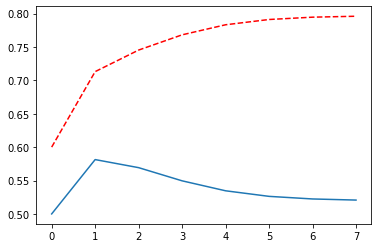

In [11]:
# E-M begins!
delta = 0.001  
j = 0 # iteration counter
improvement = float('inf')


while (improvement>delta):
    expectation_A = np.zeros((len(experiments),2), dtype=float) 
    expectation_B = np.zeros((len(experiments),2), dtype=float)
    # E-Step (Calculate LL)
    for i in range(0,len(experiments)):
        e = experiments[i] # i'th experiment
        
          # loglikelihood of e given coin A:
        ll_A = get_binomial_log_likelihood(e,np.array([pA_heads[j],1-pA_heads[j]])) 
          # loglikelihood of e given coin B
        ll_B = get_binomial_log_likelihood(e,np.array([pB_heads[j],1-pB_heads[j]])) 

          # corresponding weight of A proportional to likelihood of A 
        weightA = math.exp(ll_A) / ( math.exp(ll_A) + math.exp(ll_B) ) 

          # corresponding weight of B proportional to likelihood of B
        weightB = math.exp(ll_B) / ( math.exp(ll_A) + math.exp(ll_B) ) 
        
        # This is from the Paper (but in the tutorial we discsused a more tangible approach, try to program it)
        expectation_A[i] = np.dot(weightA, e) 
        expectation_B[i] = np.dot(weightB, e)    
        
    # M Step (Update Parameters)
    pA_heads[j+1] = sum(expectation_A)[0] / sum(sum(expectation_A)); 
    pB_heads[j+1] = sum(expectation_B)[0] / sum(sum(expectation_B)); 

    improvement = ( max( abs(np.array([pA_heads[j+1],pB_heads[j+1]]) - 
                    np.array([pA_heads[j],pB_heads[j]]) )) )
    j = j+1
    
plt.figure();
plt.plot(range(0,j),pA_heads[0:j], 'r--')
plt.plot(range(0,j),pB_heads[0:j])
plt.show()

## K-Means Clustering

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

1. The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
2. Each point is closer to its own cluster center than to other cluster centers.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

#### Generate fake data

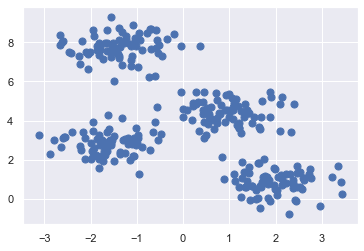

In [13]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [18]:
# Identifying the clusters with k-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

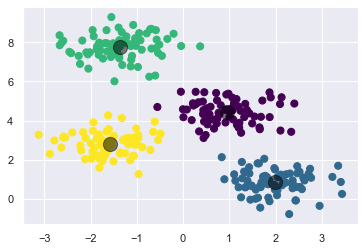

In [19]:
# Plot the clusters and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### Expectation Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here. In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
    1. E-Step: assign points to the nearest cluster center
    2. M-Step: set the cluster centers to the mean

#### A simple implementation of the EM algorithm

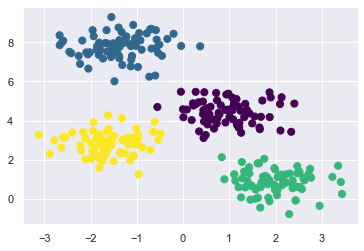

In [20]:
from sklearn.metrics import pairwise_distances_argmin

# For interested students: Analyze the caveats of expectation–maximization

#1. The globally optimal result may not be achieved
#2. The number of clusters must be selected beforehand
#3. k-means is limited to linear cluster boundaries (recall last workshop how we can create complex data)


def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    
    
    # Choose randomly n_clusteres elements from the input list X
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center (Expectation)
        labels = pairwise_distances_argmin(X, centers)
        #print(labels)
        
        # 2b. Find new centers from means of points (Maximization)
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');


### Real World Example of K-means: Image Compression

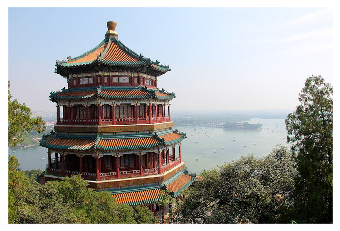

In [21]:
# Load Example Image
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [22]:
# Get (height, width, [red/blue/green]) of image
# RGB is represented as 8 Bit Integers - 0...255 => 255^3 different colors
china.shape

(427, 640, 3)

In [16]:
# Scale it 0...1

In [23]:
data = china / 255.

In [24]:
# Reshape picture to two dimensional vector
data = data.reshape(427 * 640, 3)
data.shape


# Results in a Matrix: rows: Pixel, Columns: R G B

(273280, 3)

In [25]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);


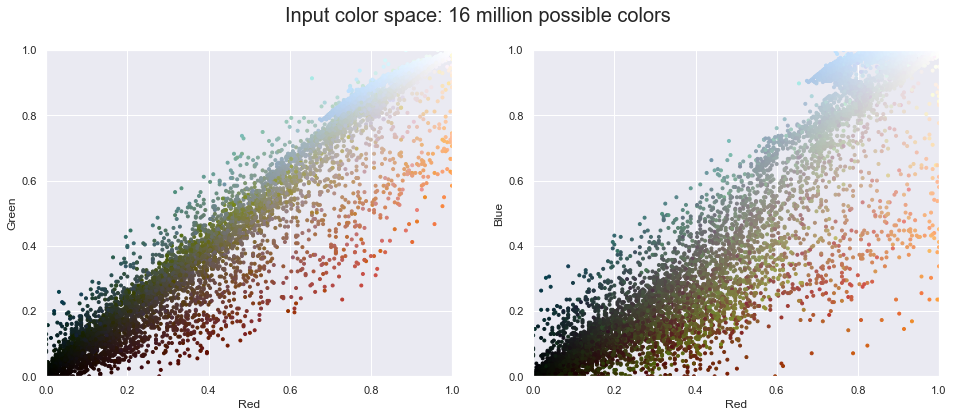

In [26]:
plot_pixels(data, title='Input color space: 16 million possible colors')

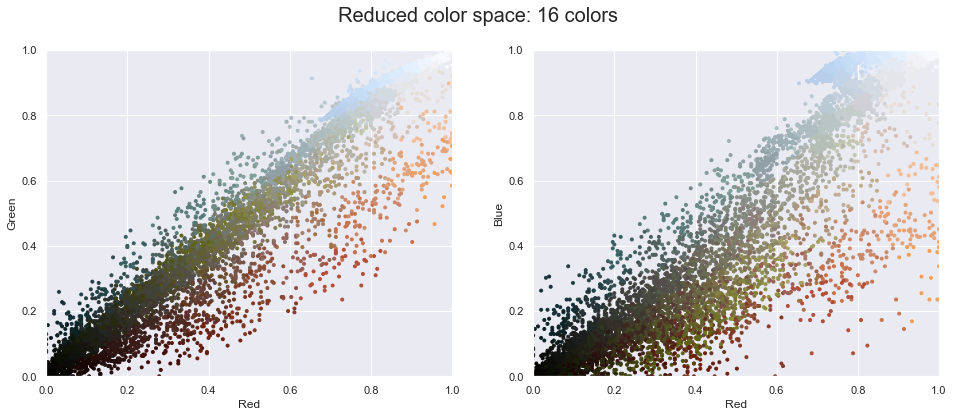

In [31]:
# Reduce these 16 Millions Colors to 16! colors
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(128) # Much faster than original K-Means due to large amount of data
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")


### Recoloring the original Image 

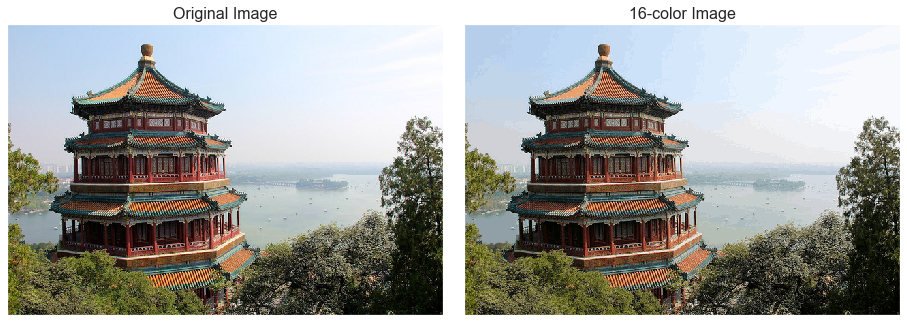

In [32]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

In [37]:
import sys
sys.getsizeof(china_recolored)

128

In [36]:
import sys
sys.getsizeof(china)

819968

# Soft Clustering with Gaussian Mixture Models

The k-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application. In particular, the non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations. In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering.

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [40]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

In [41]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

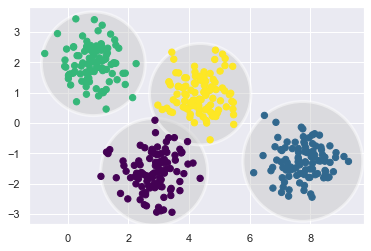

In [42]:
# Plot K-Means Clusters with their cutoff respective functions
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

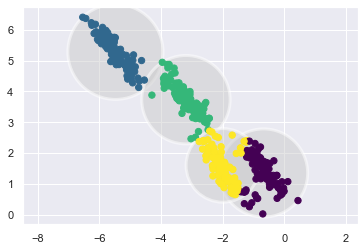

In [43]:
# This entails problems when our data is distributed not in a circular way.
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

# Nevertheless, k-means is not flexible enough to account for this, 
# and tries to force-fit the data into four circular clusters. 
# This results in a mixing of cluster assignments where the resulting 
# circles overlap: see especially the bottom-right of this plot.

### Gaussian Mixtures help to overcome these issues 

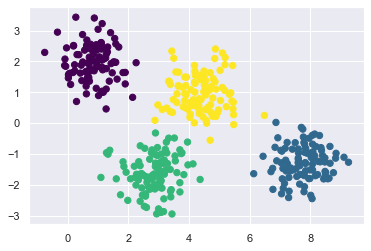

In [44]:
# As always, SKlearn provides us a neat interface to implement GMM 
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

#### But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments

In [46]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


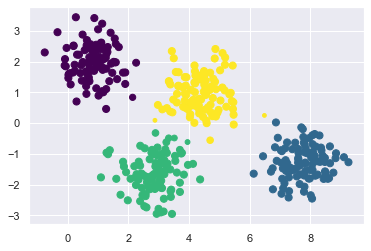

In [47]:
# Representing the certainity of cluster assignments
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);


#### Let's visualize the gaussian functions

In [48]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    # Plot the Gaussian Mixture Model
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

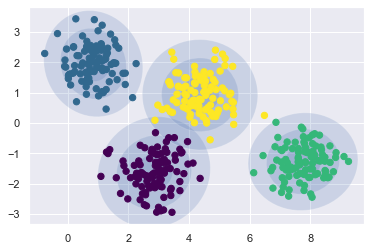

In [49]:
plot_gmm(gmm, X)

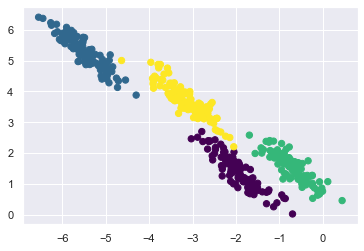

In [54]:
# As always, SKlearn provides us a neat interface to implement GMM 
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X_stretched)
labels = gmm.predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='viridis');

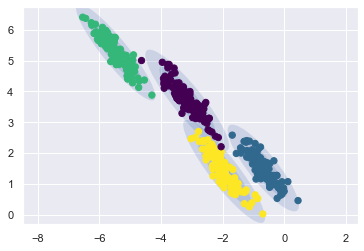

In [55]:
plot_gmm(gmm, X_stretched)

## Example: Generating "new" data from learnt distributions

In [56]:
from sklearn.datasets import load_digits
# Load Digit data
digits = load_digits()
digits.data.shape

(1797, 64)

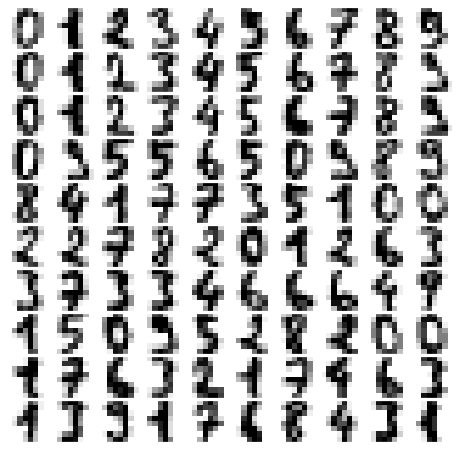

In [57]:
# plot digits
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [58]:
# GMM suffer from the curse of dimensionality, so we reduce it with PCA
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

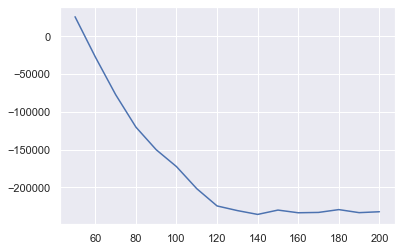

In [59]:
# Determine the optimal number of clusters (NOTE: this only works for Density Estimation)
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);


In [60]:
# It appears that 140 is the optimal number of gaussian
gmm = GaussianMixture(120, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [62]:
# Sample data from the "learnt" function
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

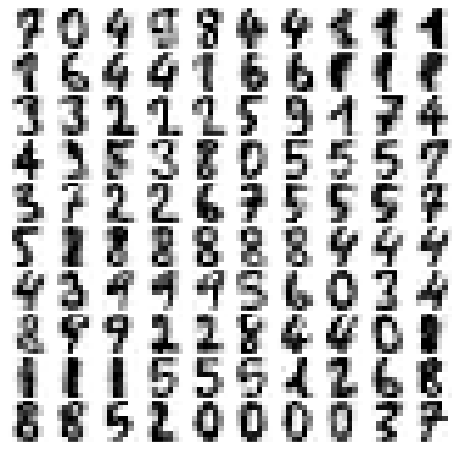

In [63]:
# Transform back to original space
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)

### This is completly new data, sampled from our GaussianMixture Density